In [15]:
!pip install yfinance --upgrade --no-cache-dir

In [16]:
!pip install pandas_ta --upgrade --no-cache-dir

In [17]:
from prophet import Prophet
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import pandas_ta as ta
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objs as go
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [18]:
# Name by which it is represented on the stock exchange.
symbol = "LREN3.SA"

# Query stock in yahoo finance
stock = yf.Ticker(symbol)

# Get 48 months data for enough sample terms
history = stock.history(period="48mo")

In [19]:
# Name by which it is represented on the stock exchange.
symbol = "LREN3.SA"

# Query stock in yahoo finance
stock = yf.Ticker(symbol)

# Get 48 months data for enough sample terms
history = stock.history(period="48mo")

# Create date column
history['date'] = history.index
history['date'] = pd.to_datetime(history["date"]).dt.date

# Reindex data using a DatetimeIndex
history.set_index(pd.DatetimeIndex(history.index), inplace=True)

# select features that have interest to us
data = history[['date','Close']].copy();

# use technical analyses using 21 one days and append to our dataset
data.ta.ema(close='Close', length=21, append=True)

# Drop empty values
data.dropna(inplace=True)

In [20]:
fig = px.line(data, x='date', y='Close')
fig.show()

In [21]:
# Add all dataset as training model
df_train = data[['date','Close','EMA_21']]

df_train = df_train.rename(columns={"date": "ds", "Close": "y"})

# Fit model
m = Prophet(daily_seasonality=True)

# Train
m.fit(df_train)

# Get dates 30 days in the future
future = m.make_future_dataframe(periods=30)

# Drop weekends
future['day'] =  future['ds'].dt.weekday
future = future[future['day'] <=4]

# Predict dates
forecast = m.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jmximro/r8fbb0vn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jmximro/qedy4_7l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24640', 'data', 'file=/tmp/tmp6jmximro/r8fbb0vn.json', 'init=/tmp/tmp6jmximro/qedy4_7l.json', 'output', 'file=/tmp/tmp6jmximro/prophet_model5s17c55p/prophet_model-20230628203929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:39:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:39:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [22]:
# Plot linear regression result
fig = go.Figure([
    go.Scatter(x=df_train['ds'], y=df_train['y'], name='Actual', mode='lines'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted', mode='lines'),
    go.Scatter(x=forecast['ds'], y=df_train['EMA_21'], name='EMA', mode='lines')
])

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [23]:

# Get all predictions
pred_df = forecast[forecast['ds'] > datetime.today()][['ds','yhat']]

# Reset Index
pred_df.reset_index(inplace=True)

# Drop index column
pred_df.drop(labels='index', axis=1,inplace=True)

# Rename columns
pred_df.rename(columns={'ds': 'date', 'yhat': 'predicted price'}, inplace=True)

# Show first elements
pred_df

,date,predicted price
0,2023-06-29,19.273953
1,2023-06-30,19.237853
2,2023-07-03,19.015194
3,2023-07-04,18.975656
4,2023-07-05,18.954172
5,2023-07-06,19.024699
6,2023-07-07,19.065711
7,2023-07-10,19.059461
8,2023-07-11,19.083215
9,2023-07-12,19.118902


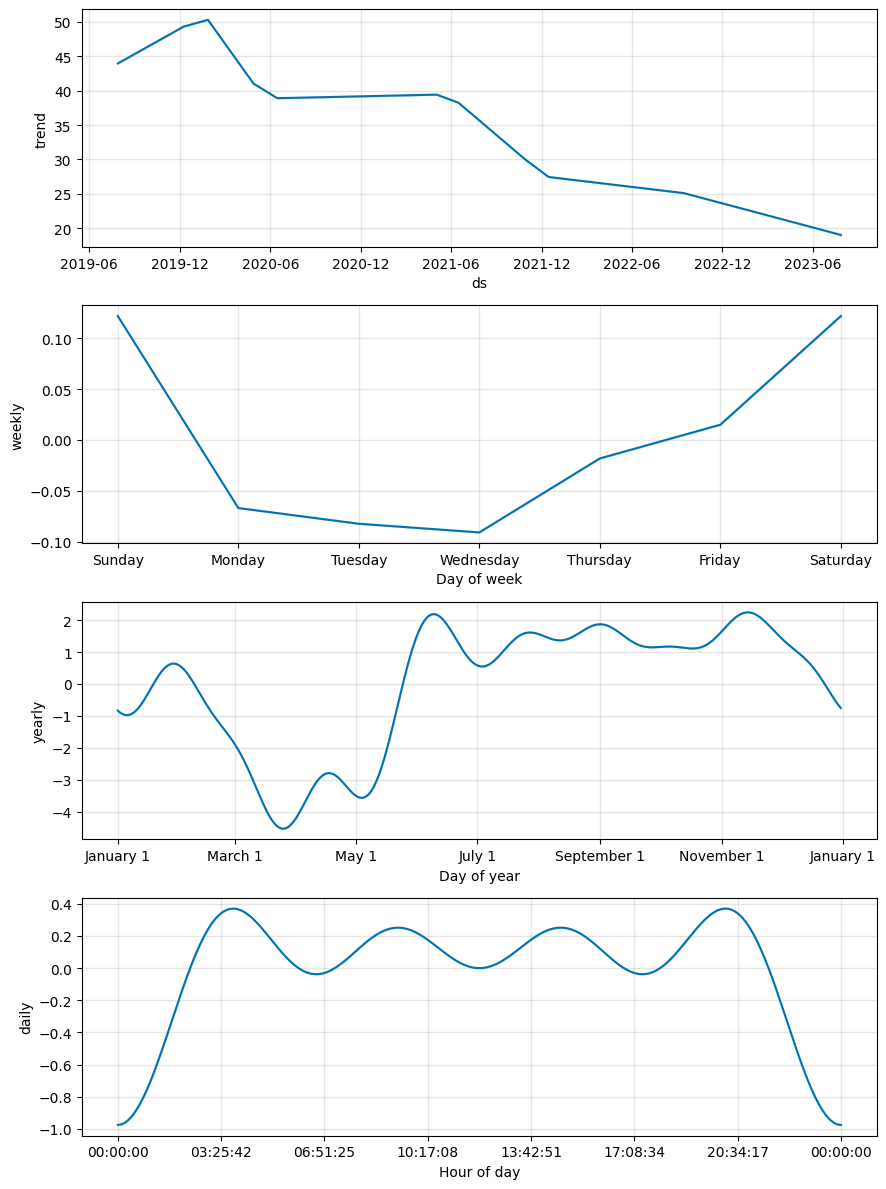

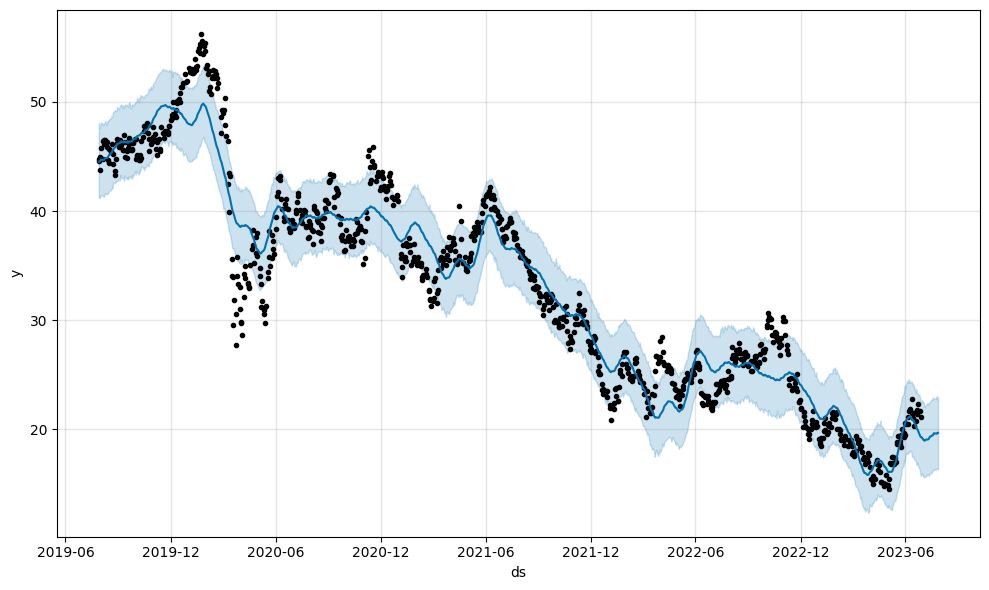

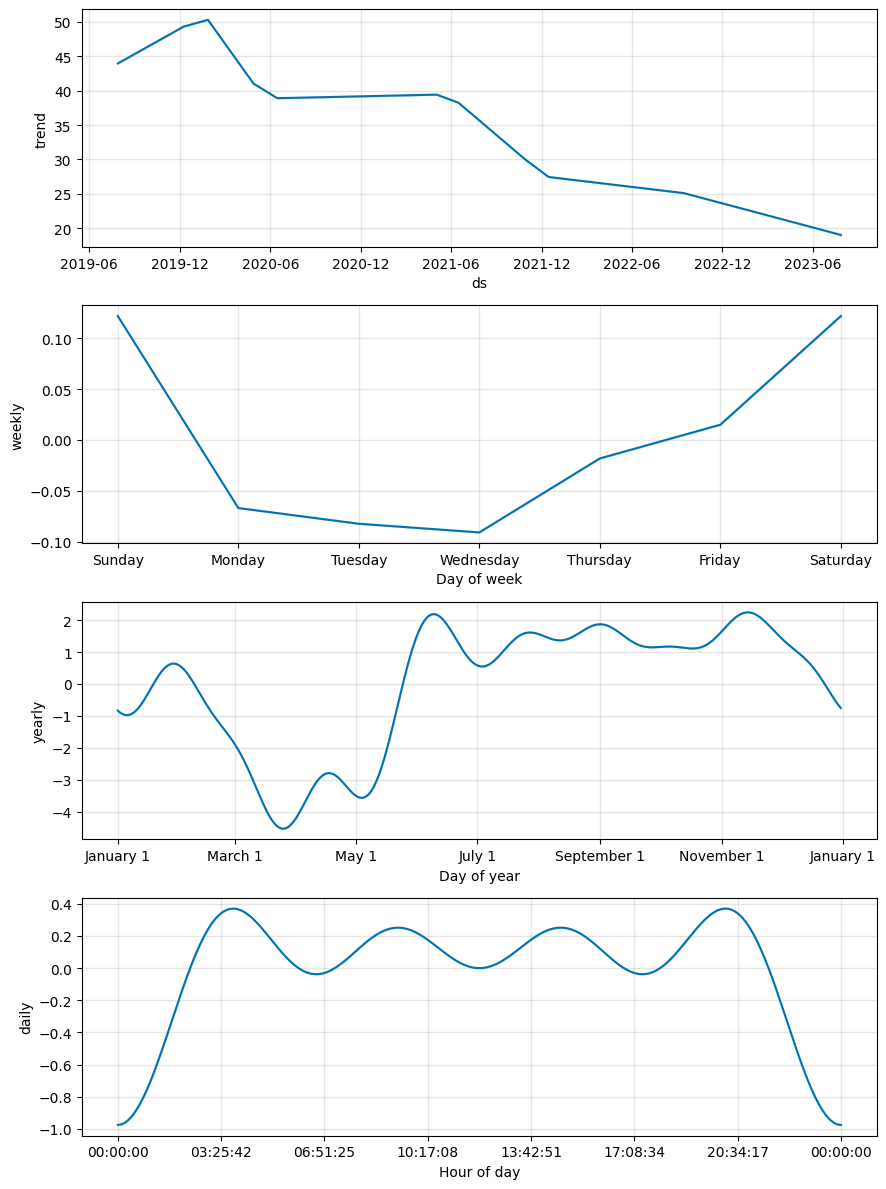

In [24]:
m.plot(forecast)
m.plot_components(forecast)

In [25]:
# execute cross validation

# reference
# https://facebook.github.io/prophet/docs/diagnostics.html#:~:text=Cross%20validation,up%20to%20that%20cutoff%20point.

df_cv = cross_validation(m, initial='720 days', period='30 days', horizon = '365 days')

# visualize data
print(df_cv.head())

# measure performance
df_p = performance_metrics(df_cv)
print(df_p.head())

INFO:prophet:Making 12 forecasts with cutoffs between 2021-08-02 00:00:00 and 2022-06-28 00:00:00


  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jmximro/nqh4tchx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jmximro/fr433x7z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64642', 'data', 'file=/tmp/tmp6jmximro/nqh4tchx.json', 'init=/tmp/tmp6jmximro/fr433x7z.json', 'output', 'file=/tmp/tmp6jmximro/prophet_model8lihq3n8/prophet_model-20230628203932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:39:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:39:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jmximro/vfo4p9t8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jmximro/fbjkv0yy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

          ds       yhat  yhat_lower  yhat_upper          y     cutoff
0 2021-08-03  41.068126   37.474142   44.635910  36.361523 2021-08-02
1 2021-08-04  41.100738   37.628495   44.772102  35.962711 2021-08-02
2 2021-08-05  41.247911   37.617581   44.765388  35.737289 2021-08-02
3 2021-08-06  41.345434   38.076386   44.857777  35.719948 2021-08-02
4 2021-08-09  41.626155   37.974533   45.068231  35.641926 2021-08-02
  horizon        mse      rmse       mae      mape     mdape     smape  \
0 37 days  34.948176  5.911698  4.390800  0.166639  0.126997  0.180270   
1 38 days  36.325627  6.027074  4.461270  0.169622  0.128441  0.183843   
2 39 days  38.053399  6.168744  4.573646  0.173960  0.131768  0.189055   
3 40 days  38.497567  6.204641  4.617826  0.176001  0.133338  0.191509   
4 41 days  38.945190  6.240608  4.674518  0.178597  0.138164  0.194525   

   coverage  
0  0.472527  
1  0.473244  
2  0.467113  
3  0.457776  
4  0.446488  
